In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


In [21]:
csv=pd.read_csv("data/fma-rock-vs-hiphop.csv")
json=pd.read_json("data/echonest-metrics.json",precise_float=True)
comb_data=pd.merge(csv[["track_id","genre_top"]],json,on="track_id")
comb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   genre_top         4802 non-null   object 
 2   acousticness      4802 non-null   float64
 3   danceability      4802 non-null   float64
 4   energy            4802 non-null   float64
 5   instrumentalness  4802 non-null   float64
 6   liveness          4802 non-null   float64
 7   speechiness       4802 non-null   float64
 8   tempo             4802 non-null   float64
 9   valence           4802 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


In [27]:
corr_metrics = comb_data.drop(["genre_top"],axis=1).corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


In [46]:
listening_features=comb_data.drop(["genre_top","track_id"],axis=1)
scaler=StandardScaler()
scaled_features=scaler.fit_transform(listening_features)
labels=comb_data["genre_top"]
scaled_features

array([[ 1.36170559, -0.98589622,  1.45332318, ..., -0.36415677,
        -1.07200261, -1.57310227],
       [ 1.31234237, -0.45568108, -2.46398518, ..., -0.49822414,
        -2.14506572, -1.5670495 ],
       [ 1.34364478, -1.60400213,  1.17609079, ..., -0.11890299,
        -1.022854  , -1.57194929],
       ...,
       [-1.29470431,  1.17682795,  0.13265633, ...,  0.85182206,
        -0.93541008, -0.07941825],
       [-1.13869115, -0.02253433,  0.57117905, ...,  1.40951543,
         1.31301348,  0.47513794],
       [-0.90611434,  1.10148973,  0.56322452, ...,  1.36030881,
        -1.43669053,  0.76217464]])

In [47]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
pca=PCA()
pca.fit(scaled_features)
variance=pca.explained_variance_ratio_

print(variance)
print(pca.n_components_)
#brak wyrozniajacego sie elementu 


[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]
8


In [48]:
def find_number(components,cutoff):
    number=0
    for i in components:
        if i<cutoff:
            number+=1
    return number


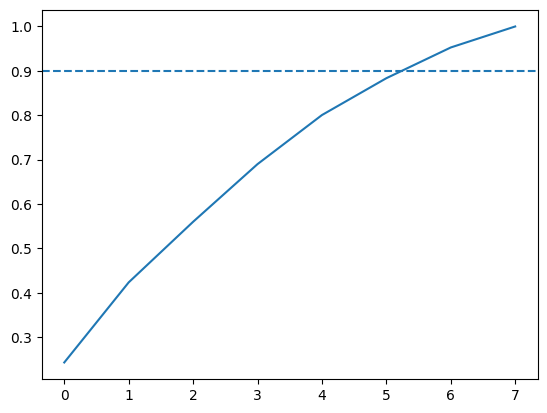

In [43]:
cumulated_variance=np.cumsum(variance)
fig, ax = plt.subplots()
ax.plot(range(8), cumulated_variance)
ax.axhline(y=0.9, linestyle='--')
n_components=find_number(cumulated_variance, 0.9)

#exclude components
pca=PCA(n_components, random_state=12)
pca.fit(scaled_features)
pca_projection=pca.transform(scaled_features)


In [57]:
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.tree import DecisionTreeClassifier

train_features,test_features,train_labels,test_labels=train_test_split(pca_projection,labels,random_state=10)
tree=DecisionTreeClassifier()
tree.fit(train_features,train_labels)
tree_guesses=tree.predict(test_features)


In [54]:

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

regression=LogisticRegression()
regression.fit(train_features,train_labels)
classification_guesses=regression.predict(test_features)

print("Decision Tree Performance:")
print(classification_report(test_labels,tree_guesses))

print("Logistic Regression Performance:")
print(classification_report(test_labels,classification_guesses))




Decision Tree Performance:
              precision    recall  f1-score   support

     Hip-Hop       0.63      0.62      0.62       229
        Rock       0.91      0.92      0.91       972

    accuracy                           0.86      1201
   macro avg       0.77      0.77      0.77      1201
weighted avg       0.86      0.86      0.86      1201

Logistic Regression Performance:
              precision    recall  f1-score   support

     Hip-Hop       0.75      0.51      0.60       229
        Rock       0.89      0.96      0.92       972

    accuracy                           0.87      1201
   macro avg       0.82      0.73      0.76      1201
weighted avg       0.86      0.87      0.86      1201



In [ ]:
#concerning: very high rock accuracy in comparison to hip hop: due to small sample

In [55]:

hop_only = comb_data.loc[comb_data["genre_top"] == "Hip-Hop"]
rock_only = comb_data.loc[comb_data["genre_top"] == "Rock"].sample(len(hop_only), random_state=10)
rock_hop_bal = pd.concat([rock_only, hop_only])

features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

In [56]:
tree=DecisionTreeClassifier()
tree.fit(train_features,train_labels)
tree_guesses=tree.predict(test_features)

regression=LogisticRegression()
regression.fit(train_features,train_labels)
classification_guesses=regression.predict(test_features)

print("Decision Tree Performance:")
print(classification_report(test_labels,tree_guesses))
print("Logistic Regression Performance:")
print(classification_report(test_labels,classification_guesses))
#diveristy vs accuracy

Decision Tree Performance:
              precision    recall  f1-score   support

     Hip-Hop       0.80      0.80      0.80       230
        Rock       0.80      0.80      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression Performance:
              precision    recall  f1-score   support

     Hip-Hop       0.89      0.83      0.86       230
        Rock       0.83      0.89      0.86       225

    accuracy                           0.86       455
   macro avg       0.86      0.86      0.86       455
weighted avg       0.86      0.86      0.86       455



In [63]:

kf = KFold(n_splits=10, random_state=10,shuffle=True)
tree=DecisionTreeClassifier(random_state=10)
regression=LogisticRegression(random_state=10)

tree_score=cross_val_score(tree,pca_projection,labels, cv=kf)
regression_score = cross_val_score(regression, pca_projection, labels, cv=kf)


print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(regression_score))

Decision Tree: 0.8142857142857143 Logistic Regression: 0.856043956043956


In [68]:
regression.fit(train_features,train_labels)
from sklearn.inspection import permutation_importance


model_fi = permutation_importance(regression,train_features, train_labels)
model_fi['importances_mean']    


array([ 3.27765568e-01,  2.93040293e-04,  9.52380952e-03, -5.86080586e-04,
        2.72527473e-02,  8.79120879e-04,  6.00732601e-02,  1.61172161e-03])